# test_Hilbert_swath
* testing Hilbert transform to extract instantaneous tidal signal and diagnoze its (statistical) properties
* this is a first version, only using SSH from one $x$-points extracted from swath files
* stationary tide was extracted previously using harmonic extraction. I think it is possible to estimate it from the Hilbert-transformed signal.

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import xarray as xr
#from xgcm import Grid
import scipy.signal as sig
import scipy.stats as stats
import os, sys

import crocosi.postp as pp
import crocosi.gridop as gop
#from crocosi.vmodes import _move_singletons_as_attrs as singletons_to_attrs


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8787') #dashboard_address=':8787'
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33016 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


load swath and clean the dataset a bit

In [3]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'

pref = "" # "file_" #
#run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
run = 'jet_cfg1_wp5_m1a1_4km_500a1000j/'
#run = 'jet_cfg1_wp5_4km_1500a2000j_itide/'
#run = 'jet_cfg1_wp0_noperturb_0a100j_floats_lev50_itide/'

what = ["swath"] # list of files to open

dosavefig = False
dirpic = os.path.join("figures", run)
fig_kwargs = {"magnification":"auto", "dpi":150, "bbox_inches":"tight"}

docal = True
dostore = False if docal else False # can't store if not computing
#file_path = '/'.join([os.getenv('SCRATCH'),run])
itbeg, itend = 0, None # None for itend, itbeg=time for the IT to fill the domain

### load dataset
%time r = pp.Run(root_path+run, prefix=pref, outputs=what, verbose=True)

ds, dg = r['swath'], r['grid']

### "clean" dataset by removing "swath" in names
stg = "_swath" 
for dim in ['x_rho', 'y_rho']:
    if dim in ds.dims:
        ds = ds.drop_dims(dim)
        print('dropped dim {} from dataset'.format(dim))
ds = ds.rename({key:key.replace(stg,"") for key in ds.keys() 
                if stg in key})
ds = ds.rename({key:key.replace(stg,"") for key in ds.dims.keys() 
                if stg in key})
#ds = ds.chunk({"time":nck_t, "y_rho":nck_y, "y_v":nck_y, "y_u":nck_y})
ds = ds.assign_coords(y_cen=((ds.y_rho - ds.y_rho[ds.y_rho.size//2])/1e3).rename('y_cen').assign_attrs(units="km"))

### select working portion of dataset, display size
ds = ds.isel(time=slice(itbeg, itend))
print("ds size in time: {0}; min={1:.3e}; max={2:.3e}".format(
    ds.time.size, ds.time_instant[0].values, ds.time_instant[-1].values))
print("ds size: {:.2f} GB".format(ds.nbytes/1e9))

Analysing directory /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp5_m1a1_4km_500a1000j/
Found 5 segments
Search for parameters in croco.in :
Parameters detected in output.mpi :
Opening datasets: grid / swath
Grid size: (L ,M, N) = (258, 722, 50)
CPU times: user 4.56 s, sys: 1 s, total: 5.56 s
Wall time: 1min 15s
dropped dim y_rho from dataset
ds size in time: 24000; min=5.000e+02; max=1.000e+03
ds size: 251.13 GB


define a few useful functions (mostly wrappers of numpy/scipy functions)

In [4]:
dt = np.diff(ds.time_instant[:10].values).mean()

def myfilt(data, Wn, btype="low", coord="time"):
    """ wrapper to call scipy.signal.filtfilt using butterworth filter 
    using xarray apply_ufunc 
    Wn = 2*dt*fcut """
    bb, aa = sig.butter(4, Wn, btype=btype)
    iax_filt = data.dims.index(coord)
    filtwrap = lambda x: sig.filtfilt(bb, aa, x, axis=iax_filt, method="gust")
    if btype in ["high", "band"]: # remove coord-average if high-pass filtering
        res = xr.apply_ufunc(filtwrap, data.chunk({coord:-1}) - data.mean(coord), 
                             dask="parallelized", 
#                         input_core_dims=[['time']], output_core_dims=[['time']],
                             output_dtypes=[np.float32])
    else:
        res = xr.apply_ufunc(filtwrap, data.chunk({coord:-1}), 
                             dask="parallelized", 
#                         input_core_dims=[['time']], output_core_dims=[['time']],
                             output_dtypes=[np.float32])
    return res

def myhilb(data, coord="time"):
    """ wrapper to call scipy.signal.hilbert 
    using xarray apply_ufunc 
    """
    iax_hil = data.dims.index(coord)
    hilwrap = lambda x: sig.hilbert(x, axis=iax_hil)
    res = xr.apply_ufunc(hilwrap, data.chunk({coord:-1}), 
                    dask="parallelized", 
#                         input_core_dims=[['time']], output_core_dims=[['time']],
                             output_dtypes=[np.complex64])
    return res

def get_ana(data, coord="time"):
    """ get analytical signal using hilbert transform. 
    Compute amplitude, phase and instantaneous frequency
    calls myhilb
    TODO : find xarray versions of numpy fonctions (ufuncs?) """
    res = xr.Dataset(coords=data.coords)
    res['ana'] = myhilb(data, coord=coord)
    res['ana'].persist()
    res['amp'] = np.abs(res['ana'])
    res['phase'] = xr.DataArray(data=np.unwrap(np.angle(res['ana']), axis=data.dims.index(coord)),
                                coords=data.coords, dims=data.dims
                               )
    res['freq'] = res['phase'].differentiate(coord)/dt/2./np.pi
    return res

def get_kde(data, coord="time", amps=None, bw_method=None, weights=None):
    """ wrapper of scipy.signal.gaussian_kde using apply_ufuncs 
    data must be a 1D or 2D DataArray for now """
    if amps is None:
        amps = np.linspace(data.min(), data.max(), 100)
    dims = list(data.dims)
    amp = data.name
    if len(dims)==1:
        print("here")
        res = stats.gaussian_kde(data, bw_method=bw_method, weights=weights)
        res = xr.DataArray(res(amps), coords={amp:amps}, dims=amp, name=data.name)
    elif len(dims)==2:
        dims.remove(coord)
        dim = dims[0]
        res = [stats.gaussian_kde(dat, bw_method=bw_method, weights=weights) 
                        for dat in data.transpose(..., coord)]
        res = xr.concat([xr.DataArray(re(amps), coords={amp:amps}, dims=amp) 
                        for re in res], dim=dim
                       ).rename(data.name).assign_coords({dim:data[dim]})
    else:
        raise ValueError("number of dims not OK")
    return res

Work on on field of interest. Compute low-frequency component and substract it to the raw signal to obtain a high-frequency signal (prior to performing Hilbert transform -- I did not check wether this is critical or not)

<xarray.Dataset>
Dimensions:       (time: 24000, x_rho: 12, y_rho: 722)
Coordinates:
    time_counter  (time) float64 500.0 500.0 500.1 500.1 ... 1e+03 1e+03 1e+03
  * x_rho         (x_rho) float32 486000.0 490000.0 ... 526000.0 530000.0
    y_cen         (y_rho) float32 dask.array<chunksize=(21,), meta=np.ndarray>
    time_instant  (time) float64 dask.array<chunksize=(24000,), meta=np.ndarray>
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
Dimensions without coordinates: time
Data variables:
    ssh           (time, y_rho, x_rho) float32 dask.array<chunksize=(24000, 21, 12), meta=np.ndarray>
    ssh_lowf      (time, y_rho, x_rho) float32 dask.array<chunksize=(24000, 21, 12), meta=np.ndarray>
    ssh_tide      (time, y_rho, x_rho) float32 dask.array<chunksize=(24000, 21, 12), meta=np.ndarray>
Attributes:
    name:         swath
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-May-04 18:36:17 GMT
    uuid:         9039365e-43aa-48d3-9ed3-0668c659f16a

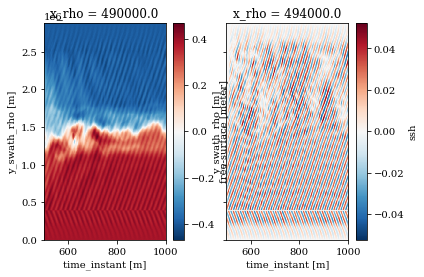

In [55]:
fields = ['ssh'] # what is written below can't handle more than one field
Tcut = 2. # [days]

ds_wk = ds[fields].chunk({"y_rho":21, "time":-1}).persist()
Wn = 2.*dt/Tcut
    
sds = xr.merge( [ myfilt(ds_wk[fie], Wn) for fie in fields ] ).persist()
ds_wk['ssh_lowf'] = sds['ssh']
ds_wk['ssh_tide'] = ds_wk['ssh'] - sds['ssh']

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
ds_wk.ssh.isel(x_rho=1).plot(x="time_instant", ax=axs[0])
(ds_wk-sds).ssh.isel(x_rho=2).plot(x="time_instant", ax=axs[1])

ds_wk

## Statistics on 3 points -- full internal tide field

In [7]:
### compute analytical signal using Hilbert transform

indx, indy = 2, [120, 720//2, 720-120]
prov = ds_wk.isel(x_rho=indx, y_rho=indy, time=slice(500, None))
prav = get_ana(prov.ssh_tide).isel(time=slice(10, -10)).persist()

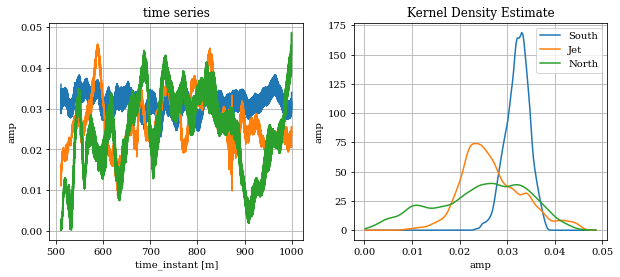

In [8]:
### Amplitude : time series and KDE
fig, axs = plt.subplots(1, 2, figsize=(10,4))

data = prav.amp
amps = np.linspace(data.min(), data.max(), 200)

data.plot.line(x="time_instant", ax=axs[0], add_legend=False)
axs[0].set_title("time series")

res = get_kde(data, amps=amps)
res.plot.line(x="amp", ax=axs[1], add_legend=False)
axs[1].legend(labels=["South","Jet","North"])
axs[1].set_title("Kernel Density Estimate")

for ax in axs:
    ax.grid(True)

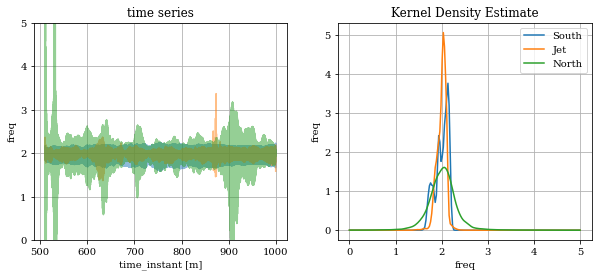

In [9]:
### Frequency : time series and KDE

fig, axs = plt.subplots(1, 2, figsize=(10,4))

data = prav.freq
amps = np.linspace(0, 5, 200)

data.plot.line(x="time_instant", ax=axs[0], add_legend=False, alpha=.5)
axs[0].set_title("time series")
axs[0].set_ylim([amps[0], amps[-1]])

res = get_kde(data, amps=amps)
res.plot.line(x="freq", ax=axs[1], add_legend=False)
axs[1].legend(labels=["South","Jet","North"])
axs[1].set_title("Kernel Density Estimate")

for ax in axs:
    ax.grid(True)

## Statistics vs y_rho -- full internal tide field


In [10]:
prov = ds_wk.isel(time=slice(500, None), x_rho=indx)
prav = get_ana(prov.ssh_tide).isel(time=slice(10, -10)).persist()

Text(0.5, 1.0, '')

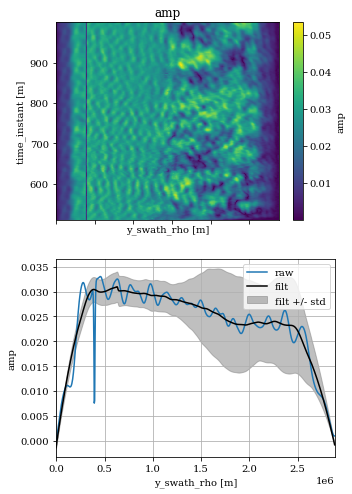

In [11]:
### Amplitude 

field = "amp"
ny_sm = 121
data = prav[field]
moy = sig.savgol_filter(data.mean("time"), ny_sm, 2)
std = sig.savgol_filter(data.std("time"), ny_sm, 2)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
data.plot(y="time_instant", ax=axs[0])
axs[0].set_title(field)
ax = axs[1]
data.mean("time").plot(ax=ax)
ax.plot(prav.y_rho, moy, "k")
ax.fill_between(prav.y_rho, moy-std, moy+std, color="grey", alpha=.5)
ax.legend(["raw", "filt", "filt +/- std"])
ax.grid(True)
ax.set_title('')

Text(0.5, 1.0, '')

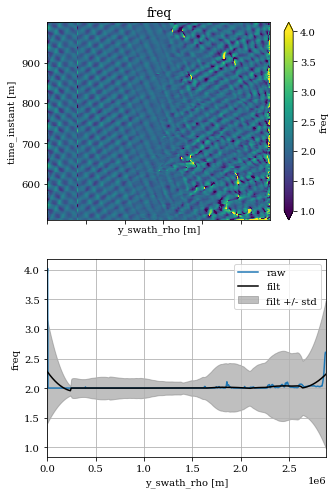

In [12]:
### Frequency

field = "freq"
ny_sm = 121
data = prav[field]
moy = sig.savgol_filter(data.mean("time"), ny_sm, 2)
std = sig.savgol_filter(data.std("time"), ny_sm, 2)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
data.plot(y="time_instant", ax=axs[0], vmin=1, vmax=4)
axs[0].set_title(field)
ax = axs[1]
data.mean("time").plot(ax=ax)
ax.plot(prav.y_rho, moy, "k")
ax.fill_between(prav.y_rho, moy-std, moy+std, color="grey", alpha=.5)
ax.legend(["raw", "filt", "filt +/- std"])
ax.grid(True)
ax.set_title('')

## Substract stationary internal tide, investigate properties of non-stationary tide

Tide has the form:
$ u = \mathcal{R}\lbrace(\overline{u} + u'(t))e^{i\omega_0 t}\rbrace $
where $\overline{u}$ is the stationary tide (for any field). We are interested in the properties of $u'$, which is obtained by computing the analytical signal of the total-stationary signal, and de-phasing it by multiplying by $e^{-i \omega_0 t}$

In [13]:
### load/compute stationary component and substrack from ssh_tide
harmo = r.load_diagnostic('harmo_extract_surf_n2')[fields]
ds_stat = (harmo.mean(["x_rho", "time"]) *2.).persist()
ds_stat

<xarray.Dataset>
Dimensions:  (y_rho: 722)
Coordinates:
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    f_rho    (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f        (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    y_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
Data variables:
    ssh      (y_rho) complex128 dask.array<chunksize=(722,), meta=np.ndarray>

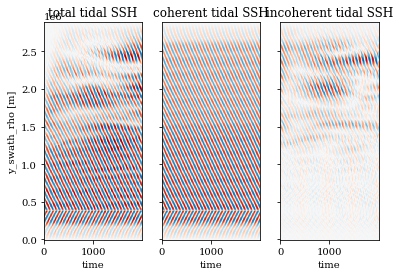

In [52]:
ds_coh = (ds_stat * np.exp(-1.j*harmo.omega*prov.time_instant)).real
ssh_inc = prov.ssh_tide - ds_coh.ssh

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
indt = slice(2000)
amp = float(abs(prov.ssh_tide.isel(time=indt)).max().values)
cmap = "RdBu_r"

prov.ssh_tide.isel(time=indt).plot(x="time", ax=axs[0], vmin=-amp, vmax=amp, 
                                   cmap=cmap, add_colorbar=False)
axs[0].set_title('total tidal SSH')
ds_coh.ssh.isel(time=indt).plot(x="time", ax=axs[1], vmin=-amp, vmax=amp, 
                                cmap=cmap, add_colorbar=False)
axs[1].set_title('coherent tidal SSH')
ssh_inc.isel(time=indt).plot(x="time", ax=axs[2], vmin=-amp, vmax=amp, 
                             cmap=cmap, add_colorbar=False)
axs[2].set_title('incoherent tidal SSH')

for ax in axs[1:]:
    ax.set_ylabel('')

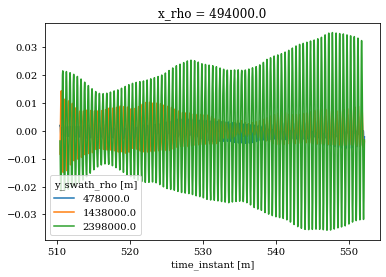

In [15]:
### Plot time series of incoherent tide
fig = plt.figure()
ssh_inc.isel(y_rho=indy, time=indt).plot.line(x="time_instant") 

distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-3a43bc885c276e6046eb2428910a45e3',)": ['tcp://127.0.0.1:37251'], "('getitem-c166fa2f267fb48307988269c9ba3c17',)": ['tcp://127.0.0.1:51339']} state: ['memory', 'memory'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:37251'], ('getitem-3a43bc885c276e6046eb2428910a45e3',)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:51339'], ('getitem-c166fa2f267fb48307988269c9ba3c17',)
NoneType: None
distributed.client - WARNING - Couldn't gather 2 keys, rescheduling {"('getitem-3a43bc885c276e6046eb2428910a45e3',)": ('tcp://127.0.0.1:37251',), "('getitem-c166fa2f267fb48307988269c9ba3c17',)": ('tcp://127.0.0.1:51339',)}
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-7e27f274a7a1c70527839ada868d2bb1',)": ['tcp://127.0.0.1:48371'], "('getitem-ae06aac6a496df7b8ca81b188086905b',)": ['tcp://127.0.0.1:37251'], "('g

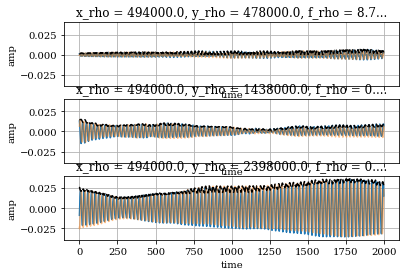

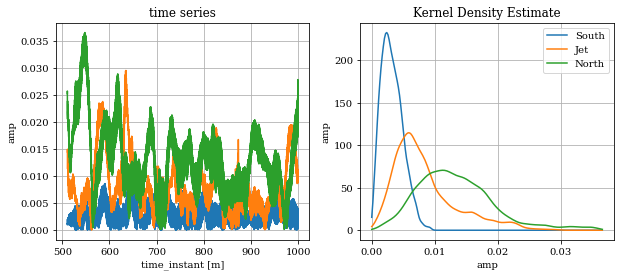

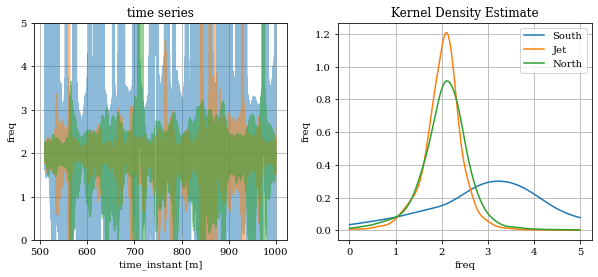

In [16]:
### three y_rho points 

prav = get_ana(ssh_inc.isel(y_rho=indy)).isel(time=slice(10, -10)).persist()

fig, axs = plt.subplots(len(indy), 1, sharex=True, sharey=True) #test reconstruction
for ia,ax in enumerate(axs):
    pra = prav.isel(y_rho=ia, time=indt)
    pra.ana.real.plot(ax=ax)
    pra.ana.imag.plot(ax=ax, alpha=.5)
    pra.amp.plot(ax=ax, color="k", linestyle="--")
    ax.grid(True)
    
### Amplitude : time series and KDE
fig, axs = plt.subplots(1, 2, figsize=(10,4))
data = prav.amp
amps = np.linspace(data.min(), data.max(), 200)

data.plot.line(x="time_instant", ax=axs[0], add_legend=False)
axs[0].set_title("time series")

res = get_kde(data, amps=amps)
res.plot.line(x="amp", ax=axs[1], add_legend=False)
axs[1].legend(labels=["South","Jet","North"])
axs[1].set_title("Kernel Density Estimate")

for ax in axs:
    ax.grid(True)
    
### Frequency : time series and KDE
fig, axs = plt.subplots(1, 2, figsize=(10,4))
data = prav.freq
amps = np.linspace(0, 5, 200)

data.plot.line(x="time_instant", ax=axs[0], add_legend=False, alpha=.5)
axs[0].set_title("time series")
axs[0].set_ylim([amps[0], amps[-1]])

res = get_kde(data, amps=amps)
res.plot.line(x="freq", ax=axs[1], add_legend=False)
axs[1].legend(labels=["South","Jet","North"])
axs[1].set_title("Kernel Density Estimate")

for ax in axs:
    ax.grid(True)

Text(0.5, 1.0, 'de-phased incoherent tide, real part')

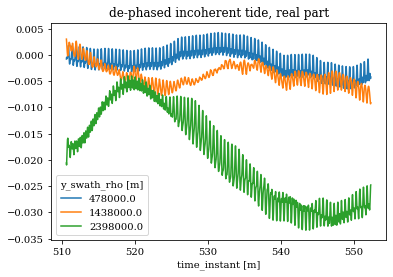

In [35]:
### Sample of de-phased inconherent tide (u')
priv = prav.isel(time=indt)
(priv.ana*np.exp(-1.j*harmo.omega*priv.time_instant)).real.plot.line(x="time_instant")
plt.title('de-phased incoherent tide, real part')

**auto / cross correlation:**
This part needs further clarification

In [37]:
### take a look at auto and cross correlation
def mycorr(data, data2=None, coord="time"):
    if data2 is None:
        data2 = data
    dims = list(data.dims)
    lags = data.time_instant-data.time_instant[0]
    lags = np.r_[-lags.values[:0:-1], lags.values]
    if len(dims)==1:
        res = sig.correlate(data, data2)
        res = xr.DataArray(res, coords={"lag":lags}, dims="lag")

    elif len(dims)==2:
        dims.remove(coord)
        dim = dims[0]
        res = [sig.correlate(dat, dot) for dat,dot in 
               zip(data.transpose(..., coord), data2.transpose(..., coord))]
        res = xr.concat([xr.DataArray(re, coords={"lag":lags}, dims="lag") 
                        for re in res], dim=dim
                       ).rename(data.name).assign_coords({dim:data[dim]})
    return res

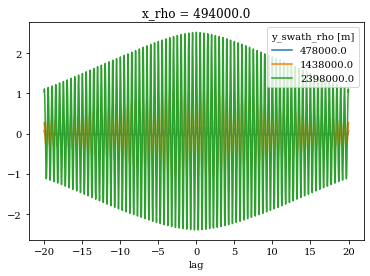

In [38]:
res = mycorr(ssh_inc.isel(y_rho=indy))
res.sel(lag=slice(-20, 20)).plot.line(x="lag")

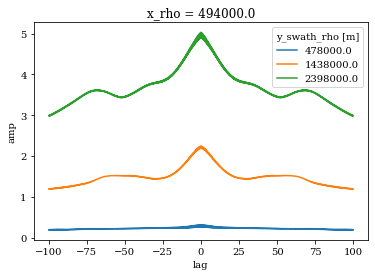

In [39]:
# auto_correlation of amplitude
res = mycorr(prav.amp)
res.sel(lag=slice(-100, 100)).plot.line(x="lag")

## Auto / cross - correlation
Probably the most important result : auto- and cross-correlation of the real part and imaginary part of the de-phased analytical signal of the incoherent tide. 
* Most certainly this has to be extended to several $x$-points to gain statistical significance
* so far, it looks like $R_{xx} \neq R_{yy}$ and $R_{xy}\neq 0$ (but smaller than the other two ones), which is not exactly what we expected

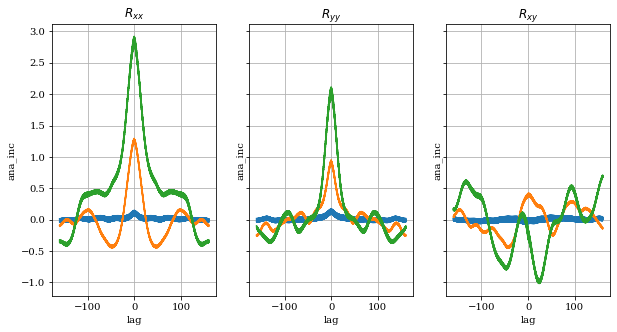

In [48]:
# auto correlation of real and imaginary part, and then cross-correlation
prav['ana_inc'] = prav.ana * np.exp(-1.j*harmo.omega*prav.time_instant)
lagmax = 160
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,5))

res = mycorr(prav.ana_inc.real)
res.sel(lag=slice(-lagmax, lagmax)).plot.line(x="lag", ax=axs[0], add_legend=False)
res = mycorr(prav.ana_inc.imag)
res.sel(lag=slice(-lagmax, lagmax)).plot.line(x="lag", ax=axs[1], add_legend=False)
res = mycorr(prav.ana_inc.real, prav.ana_inc.imag)
res.sel(lag=slice(-lagmax, lagmax)).plot.line(x="lag", ax=axs[2], add_legend=False)

tits = r"$R_{xx}$", r"$R_{yy}$", r"$R_{xy}$"
for ax,tit in zip(axs,tits):
    ax.grid(True)
    ax.set_title(tit)

## Non-stationary tide and incoherent fraction vs y

Text(0.5, 1.0, '')

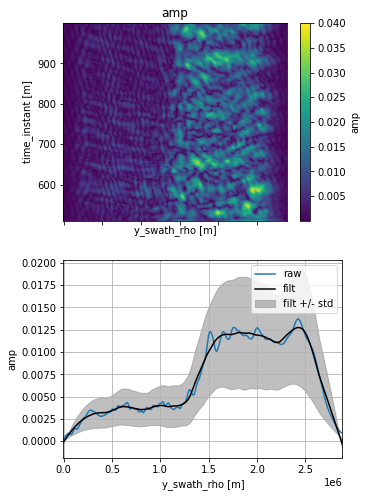

In [59]:
prav = get_ana(ssh_inc).isel(time=slice(10, -10)).persist()

### Amplitude 

field = "amp"
ny_sm = 121
data = prav[field]
moy = sig.savgol_filter(data.mean("time"), ny_sm, 2)
std = sig.savgol_filter(data.std("time"), ny_sm, 2)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
data.plot(y="time_instant", ax=axs[0])
axs[0].set_title(field)
ax = axs[1]
data.mean("time").plot(ax=ax)
ax.plot(prav.y_rho, moy, "k")
ax.fill_between(prav.y_rho, moy-std, moy+std, color="grey", alpha=.5)
ax.legend(["raw", "filt", "filt +/- std"])
ax.grid(True)
ax.set_title('')

N.B.: the fraction is defined as the amplitude of nonstat / amplitude of stat, but probably we should use something like nonstat/total.

Text(0.5, 1.0, 'non-stationarity fraction')

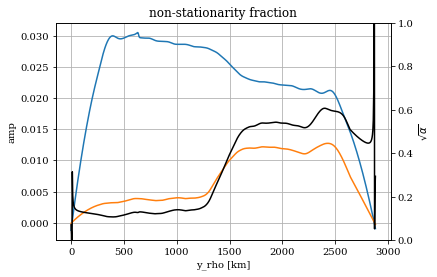

In [73]:
moy_stat = sig.savgol_filter(abs(ds_stat.ssh), ny_sm, 2)
fig = plt.figure()
ax = plt.gca()

ax.plot(prov.y_rho/1e3, moy_stat, label="coherent")
ax.plot(prov.y_rho/1e3, moy, label="incoherent")
bx = ax.twinx()
bx.plot(prov.y_rho/1e3, moy/moy_stat, "k")
bx.set_ylim([0, 1])
ax.grid(True)
ax.set_xlabel("y_rho [km]")
ax.set_ylabel('amp')
bx.set_ylabel(r'$\sqrt{\alpha}$')
plt.title('non-stationarity fraction')